In [51]:
import pandas as pd
import numpy as np
from math import factorial
from itertools import chain

import matplotlib as mpl
from matplotlib import pyplot as plt

def ecdf(x):
    '''
    Computes an ECDF for a list or tuple of values

    Param
    _____
    x : list or tuple
        A list of integers or floats containing the data
        for which the function will calculate the ECDF

    Returns
    _______

    output : two numpy arrays
        The x and y values of an ECDF plot
    
    '''
    
    return np.sort(x), np.linspace(0,1,len(x))

def poisson(n,lamb):
    '''
    Probability mass function of the Poisson distribution

    Params
    ______

    n : int
        The number of filled streptavidin pockets

    lamb : float
        The molar ratio of biotin to streptavidin. Used as
        the moment (mean and variance) of the Poisson 
        distribution

    Returns
    _______

    output : float
        The fraction of streptavidin with n binding pockets
        filled with the given lambda value
    '''
    
    return np.e**-lamb * lamb**n / factorial(n)

def strep_bio_model(lamb,
                    mode='PMF'):
    '''
    Uses the Poisson model to return either the PMF
    or CDF of streptavidin pockets filled under different
    biotin/streptavidin ratio

    Params
    ______

    lamb : list
        A list of biotin/streptavidin ratios to be evaluated

    mode : str
        Whether to return the Probability Mass Function (PMF)
        or the Cumulative Distribution Function (CDF) of 
        binding

    Returns
    ______

    output : dict
        A dictionary with lambdas as keys and CDF
        or PMF lists as values
        
    '''
    # Binding pocket states
    n = [0,1,2,3,4]

    # Dictionary to store distributions
    rdict = {}

    for r in lamb:
        # Calculate PMF
        fracs = [[i,poisson(i,r)] for i in n]

        # Lump n > 4 probabilities into n = 4 due
        # to streptavidin saturation
        gfour = 1 - np.sum([i[1] for i in fracs])
        fracs[-1][1] = fracs[-1][1] + gfour

        # Update dictionary with PMF or CDF
        if mode == 'PMF':
            # Reshape for plotting
            x = [i[0] for i in fracs]
            y = [i[1] for i in fracs]
            
            rdict[r] = [x,y]
        elif mode == 'CDF':
            cdf = []
            
            for i,v in enumerate(fracs):
                cdf_val = np.sum([j[1] for j in fracs[:i+1]])
                cdf.append([v[0],cdf_val])

            # Reshape for plotting
            x = [i[0] for i in cdf]
            y = [i[1] for i in cdf]
            
            rdict[r] = [x,y]

    return rdict

### Figures 1a and b: Poisson modeling

In [2]:
# Evaluate for optimal binding for Figure 1a
lambs = np.linspace(0.8,2,100)
fracs = []

for r in lambs:
    fracs.append(np.sum([poisson(1,r),poisson(2,r)]))

fracs[:5]

[0.5032484398112882,
 0.5069033177720693,
 0.5104615141592339,
 0.5139240517683974,
 0.5172919521368775]

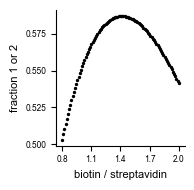

In [18]:
# Plot Figure 1a
fig,ax = plt.subplots(figsize=(2,2))

ax.scatter(lambs,fracs,s=2,c='black')
ax.set_xlabel('biotin / streptavidin', fontname='Arial', fontsize=8)
ax.set_ylabel('fraction 1 or 2', fontname='Arial', fontsize=8)
ax.set_xticks(np.linspace(0.8,2,5))
ax.spines[['top','right']].set_visible(False)

for ticks in ax.get_xticklabels():
    ticks.set_fontname('Arial')
    ticks.set_fontsize(6)

for ticks in ax.get_yticklabels():
    ticks.set_fontname('Arial')
    ticks.set_fontsize(6)

plt.tight_layout()
plt.savefig('images/Fig1a_optFrac.png',dpi=600,transparent=True)
plt.show()

In [4]:
# Evaluate model for four ratios for Figure 1b
model = strep_bio_model([0.5,1,2,4],
                        mode='CDF')

model[1]

[[0, 1, 2, 3, 4],
 [0.36787944117144233,
  0.7357588823428847,
  0.9196986029286058,
  0.9810118431238463,
  1.0]]

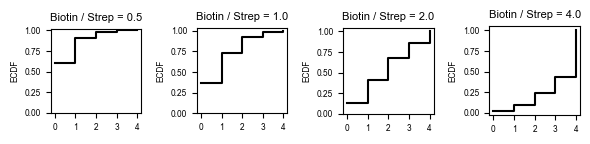

In [70]:
# Plot CDFs (Figure 1b)
fig, ax = plt.subplots(1,4,figsize=(6,2))

for k,a in zip(model,ax):
    a.step(*model[k],where='post',c='black')
    a.set_title('Biotin / Strep = '+str(float(k)),fontname='Arial',fontsize=8,)
    a.set_ylabel('ECDF',fontname='Arial',fontsize=6)

    a.set_xticks([0,1,2,3,4])
    a.set_yticks([0,0.25,0.50,0.75,1.00])
    a.set_aspect(4, adjustable='box')

    for tick in a.get_xticklabels():
        tick.set_fontname('Arial')
        tick.set_fontsize(6)

    for tick in a.get_yticklabels():
        tick.set_fontname('Arial')
        tick.set_fontsize(6)

fig.tight_layout()

plt.savefig('images/Fig1b_cdf.png',dpi=300,transparent=True)

plt.show()

In [6]:
# Additionally, calculate fraction in the 1 and 2 bins
# These are added in photoshop later
for k,v in model.items():
    frok = np.sum(v[1][2] - v[1][0])
    print(k, round(frok,2))

0.5 0.38
1 0.55
2 0.54
4 0.22


### Figure 1c: Antibody-ID distributions

In [7]:
# Rep1
r1_4 = pd.read_excel('data/20241104_RiboSPIDR_readdistributions.xlsx',
                     sheet_name=0)
r1_4 = r1_4[r1_4['Label'].str.contains('-')]
r1_4['clustFrac'] = r1_4['Cluster Counts'] / np.sum(r1_4['Cluster Counts'])

# Rep2
r2_5a = pd.read_excel('data/20241104_RiboSPIDR_readdistributions.xlsx',
                     sheet_name=1)
r2_5a = r2_5a[r2_5a['Label'].str.contains('-')]
r2_5a['clustFrac'] = r2_5a['Cluster Counts'] / np.sum(r2_5a['Cluster Counts'])

In [8]:
# Calculate ideal distribution
ntargets = len(np.unique(r2_5a['Label']))
ideal = (0, 1/ntargets, 1/ntargets, 0.18), (0,0,1,1)

# Calculate replicate ECDFs
r1_dist = ecdf(r1_4['clustFrac'])
r2_dist = ecdf(r2_5a['clustFrac'])

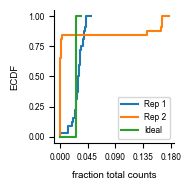

In [66]:
# Initiate figure
fig,ax = plt.subplots(figsize=(2,2))

# ECDFs
r1_step, = ax.step(*r1_dist, label='Rep 1',c='C0')
r2_step, = ax.step(*r2_dist, label='Rep 2',c='C1')
ideal_step, = ax.step(*ideal, label='Ideal',c='C2')

# Text styling
for tick in ax.get_xticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)
for tick in ax.get_yticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)

ax.set_xticks(np.linspace(0,0.18,5))
ax.set_yticks(np.linspace(0,1,5))

ax.set_ylabel('ECDF',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',
              rotation='vertical')
ax.set_xlabel('fraction total counts',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',)

ax.legend(handles=[r1_step,r2_step,ideal_step],
          prop={'family':'Arial','size':6})

ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig('images/Fig1c_readDist.png',dpi=300,transparent=True)
plt.show()

### Figure 1d: Concentration and cluster size correlation

In [10]:
data = pd.read_excel('data/20240702_SeqStatsQubit.xlsx')

data['Conc (nM)'] = np.round(1000*data['Qubit ssDNA (ng/µl)']/((19*615.96)+36.04),2)

data.head()

,Label,Clusters,Qubit ssDNA (ng/µl),RNA,RNA/Cluster,Nanodrop (oDNA),Nanodrop (ssDNA),Conc (nM)
0,Lin28b-E6,892897,3.40,55206,0.061828,6.6,6.4,0.29
1,Ilf3-E8,840764,5.98,310270,0.369033,6.9,6.8,0.51
2,Ddx52-E7,834805,6.26,57955,0.069423,7.4,7.4,0.53
3,DDX46-C4,3455,7.00,1089,0.315195,8.2,8.9,0.60
4,eIF3J-C6,3200,5.74,108,0.033750,8.8,9.4,0.49


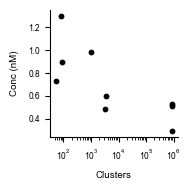

In [83]:
fig,ax = plt.subplots(figsize=(2,2))

ax.scatter(data['Clusters'],data['Conc (nM)'],s=10,c='black')
ax.set_xscale('log')
ax.set_xticks([10**2,10**3,10**4,10**5,10**6])

n_minor = 10
exp = range(2,6)
minor_xticks = [np.linspace(10**i,10**(i+1),n_minor) for i in exp]
minor_xticks = list(chain.from_iterable(minor_xticks))
minor_xticks = minor_xticks+list(np.linspace(50,90,int(n_minor/2)))
ax.set_xticks(minor_xticks,minor=True,labels='')
ax.set_yticks([0.4,0.6,0.8,1.0,1.2])

ax.spines[['top','right']].set_visible(False)

# Text styling
for tick in ax.get_xticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)
for tick in ax.get_yticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)

ax.set_ylabel('Conc (nM)',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',
              rotation='vertical')
ax.set_xlabel('Clusters',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',)

plt.tight_layout()
plt.savefig('images/Fig1d_concCluster.png',dpi=300,transparent=True)
plt.show()

### Figure 1e: Antibody-ID Concentrations

In [12]:
# Import concentrations
conc = pd.read_csv('data/20240724_ssDNA-Conc.csv',usecols=['Nucleic Acid(ng/uL)'])

rows = ['C','D','E','F']
pos = []

for r in rows:
    for i in range(12):
        pos.append(r+'_'+str(i+1))

conc['pos'] = pos
conc['row'] = [i.split('_')[0] for i in pos]
conc['col'] = [i.split('_')[1] for i in pos]
conc['Conc (nM)'] = np.round(1000*conc['Nucleic Acid(ng/uL)']/((19*615.96)+36.04),2)

conc.head()

,Nucleic Acid(ng/uL),pos,row,col,Conc (nM)
0,147.627,C_1,C,1,12.58
1,140.923,C_2,C,2,12.00
2,136.761,C_3,C,3,11.65
3,153.172,C_4,C,4,13.05
4,138.159,C_5,C,5,11.77


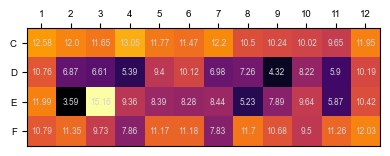

In [87]:
cvals = np.array(conc['Conc (nM)']).reshape(4,12)

fig, ax = plt.subplots(figsize=(4,2))
im = ax.imshow(cvals,cmap='inferno')

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(rows)), 
              labels=rows,
              fontsize=7,
              fontname='Arial')
ax.set_xticks(np.arange(len(range(1,13))), 
              labels=range(1,13),
              fontsize=7,
              fontname='Arial',)
ax.tick_params(top=True, labeltop=True,
               bottom=False, labelbottom=False)

# Loop over data dimensions and create text annotations.
for i in range(len(rows)):
    for j in range(12):
        text = ax.text(j, i, cvals[i, j],
                       ha="center", va="center", color="lightgray",
                       fontsize=6,fontname='Arial')

plt.margins(tight=True)
plt.tight_layout()
#plt.savefig('images/Fig1e_plateConc.png',dpi=300,transparent=True)
plt.show()

### Figure 1f: Quality control and SPIDR antibody-ID distributions

In [14]:
# Rep 3 QC
r3qc = pd.read_excel('data/20240729_SeqStats_DH_RiboSPIDR_Rep3-QC.xlsx')
r3qc['clustFrac'] = r3qc['Counts'] / np.sum(r3qc['Counts']) 
r3qc['Label'] = [i.split('_')[-1][:-1] for i in r3qc['Bead Label']]

# Calculate replicate 3 QC ECDF
r3qc_dist = ecdf(r3qc['clustFrac'])

r3qc.head()

,Counts,Bead Label,clustFrac,Label
0,123375,BEAD_Ilf3-E8],0.031319,Ilf3-E8
1,122502,BEAD_Lin28b-E6],0.031098,Lin28b-E6
2,114740,BEAD_E10],0.029127,E10
3,112388,BEAD_RPL36-D1],0.028530,RPL36-D1
4,110807,BEAD_TINP1_NSA2-E2],0.028129,NSA2-E2


In [15]:
# Rep3 Final
r3 = pd.read_excel('data/20241104_RiboSPIDR_readdistributions.xlsx',
                     sheet_name=2)
r3 = r3[r3['Label'].str.contains('-')]
r3['clustFrac'] = r3['Cluster Counts'] / np.sum(r3['Cluster Counts'])

# Calculate replicate 3 QC ECDF
r3_dist = ecdf(r3['clustFrac'])

r3.head()

,Label,Cluster Counts,Read Counts,Reads/Cluster,clustFrac
1,ILF3-E8,946138,4219871,4.460101,0.031479
2,LIN28B-E6,906364,375916,0.414752,0.030156
3,EIF2D-C7,897550,230590,0.256910,0.029863
4,PES1-C9,880494,3026466,3.437236,0.029295
5,TINP1-E2,878299,31954,0.036382,0.029222


In [16]:
# Calculate ideal distribution
ntargets = len(r3)
ideal = (0, 1/ntargets, 1/ntargets,0.035), (0,0,1,1)

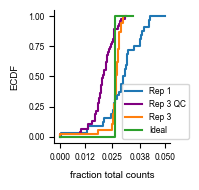

In [84]:
# Initiate figure
fig,ax = plt.subplots(figsize=(2.2,2))

# ECDFs
r1_step, = ax.step(*r1_dist, label='Rep 1',c='C0')
r3qc_step, = ax.step(*r3qc_dist, label='Rep 3 QC',c='purple')
r3_step, = ax.step(*r3_dist, label='Rep 3',c='C1')
ideal_step, = ax.step(*ideal, label='Ideal',c='C2')

# Text styling
for tick in ax.get_xticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)
for tick in ax.get_yticklabels():
    tick.set_fontname('Arial')
    tick.set_fontsize(6)

ax.set_xticks(np.round(np.linspace(0,0.05,5),3))
ax.set_yticks(np.linspace(0,1,5))

ax.set_ylabel('ECDF',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',
              rotation='vertical')
ax.set_xlabel('fraction total counts',
              labelpad=10,
              ha='center',
              va='center',
              fontsize=7,
              fontname='Arial',)

ax.legend(handles=[r1_step,r3qc_step,r3_step,ideal_step],
          loc='lower right',
          bbox_to_anchor=(1.2,0),
          prop={'family':'Arial','size':6})

ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig('images/Fig1f_readDist.png',dpi=300,transparent=True)
plt.show()